#### Compressive Sensing - Synthetic Examples

In [1]:
# External dependencies

import numpy as np
from numpy.linalg import pinv
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from scipy.signal import convolve
from scipy.optimize import minimize
from skimage.restoration import denoise_tv_chambolle  # For total variation minimization (TVM)
import cvxpy as cp

In [2]:
# Synthetic data

# Ricker wavelet function
def ricker_wavelet(points, a):
    t = np.arange(-points // 2, points // 2)
    y = (1 - 2 * (a * t / points) ** 2) * np.exp(-(a * t / points) ** 2)
    return y

# Reflectivity model
n_rows, n_cols = 50, 50
reflectivity_model = np.zeros((n_rows, n_cols))

# Dipping event
for i in range(n_rows):
    slope = 2  # Controls the dip
    j = int(i * slope)  # Calculate horizontal position for the dipping event
    if j < n_cols:
        reflectivity_model[i, j:j+2] = 1  # Add a dip with a unit reflectivity

# Convolution with reflectivity model
wavelet = ricker_wavelet(points=32, a=4)
synthetic_seismic_section = convolve(reflectivity_model, wavelet[:, np.newaxis], mode='same')

C:\Users\cco\AppData\Local\Temp\ipykernel_54380\3728017413.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


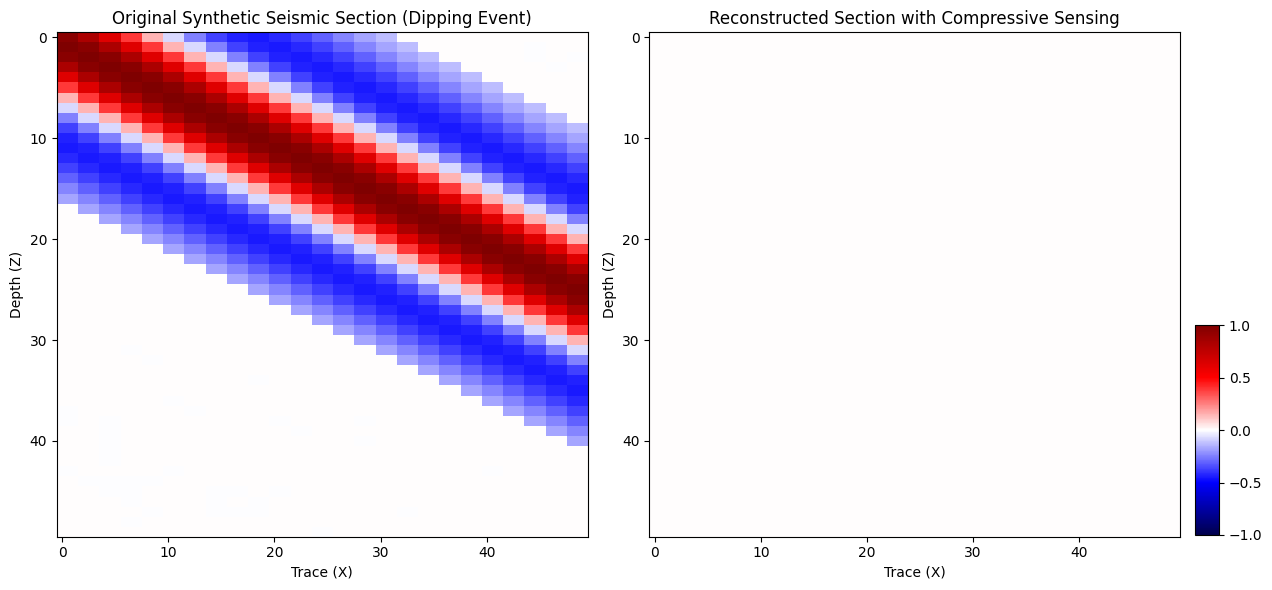

Mean Squared Error of Reconstruction: 0.1396


In [3]:
# Compressive sensing sampling

sparsity_fraction = 0.1
sampling_mask = np.random.rand(n_rows, n_cols) < sparsity_fraction
observed_data = np.zeros_like(synthetic_seismic_section)
observed_data[sampling_mask] = synthetic_seismic_section[sampling_mask]

# Data flatten for Lasso
y = observed_data.flatten()
X = np.eye(n_rows * n_cols)

# Observed (non-zero) samples
y_sparse = y[sampling_mask.flatten()]
X_sparse = X[sampling_mask.flatten(), :]

# Sparse reconstruction using Lasso
alpha = 0.01
lasso = Lasso(alpha=alpha, max_iter=1000)
lasso.fit(X_sparse, y_sparse)
reconstructed_section = lasso.coef_.reshape(n_rows, n_cols)


# Plots

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original seismic section
axes[0].imshow(synthetic_seismic_section, cmap="seismic", aspect="auto", vmin=-1, vmax=1)
axes[0].set_title("Original Synthetic Seismic Section (Dipping Event)")
axes[0].set_xlabel("Trace (X)")
axes[0].set_ylabel("Depth (Z)")

# Reconstructed section
axes[1].imshow(reconstructed_section, cmap="seismic", aspect="auto", vmin=-1, vmax=1)
axes[1].set_title("Reconstructed Section with Compressive Sensing")
axes[1].set_xlabel("Trace (X)")
axes[1].set_ylabel("Depth (Z)")

# Colorbar
cbar_ax_seis = fig.add_axes([1.0, 0.10, 0.02, 0.35])  # [left, bottom, width, height]
cbar_seis = fig.colorbar(axes[1].images[0], cax=cbar_ax_seis, orientation='vertical')

plt.tight_layout()
plt.show()

# Calculate and print reconstruction error
mse = mean_squared_error(synthetic_seismic_section.flatten(), reconstructed_section.flatten())
print(f"Mean Squared Error of Reconstruction: {mse:.4f}")


In [4]:
# Steve Brunton - https://www.youtube.com/watch?v=_-Jkq-Faa2Y&t=22s

# Solve y = Theta * s for "s"
n = 100 # dimension of s
p = 50#int(sparsity_fraction * (n_rows * n_cols)) # number of measurements
print(f"Samples from orignal image = {p}")
Theta = np.random.randn(p,n)
y = np.random.randn(p)

# L1 norm function
def L1_norm(x):
    return np.linalg.norm(x, ord=1)

# L1 Minimum norm solution s_L1
constr = ({'type': 'eq', 'fun': lambda x: Theta @ x - y})
x0 = np.linalg.pinv(Theta) @ y # Initialize with L2 solution
res = minimize(L1_norm, x0, method='SLSQP', constraints=constr)
s_L1 = res.x

Samples from orignal image = 50


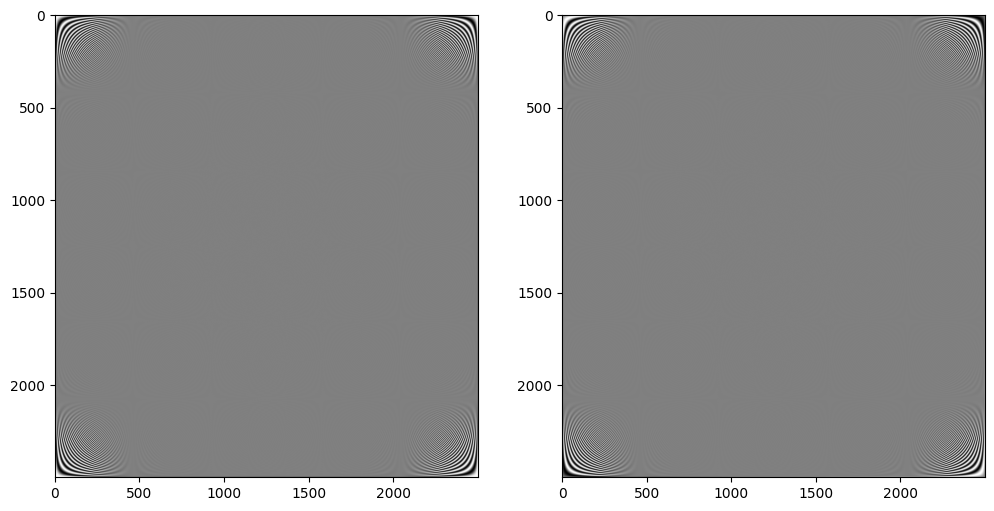

In [5]:
# https://matthew-brett.github.io/teaching/fourier_basis.html

# Fourier basis matrix construction, cosine (C) and sine (S)
N=2500
C = np.zeros((N, N))
S = np.zeros((N, N))
ns = np.arange(N)
one_cycle = 2 * np.pi * ns / N
for k in range(N):
    t_k = k * one_cycle
    C[k, :] = np.cos(t_k)
    S[k, :] = np.sin(t_k)


# Plot Fourier basis matrices

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(C, cmap="gray", aspect="auto")
axes[1].imshow(S, cmap="gray", aspect="auto")
plt.show()

In [6]:
# Steve Brunton - https://www.youtube.com/watch?v=_-Jkq-Faa2Y&t=22s

synthetic_seismic_section = synthetic_seismic_section

# Solve y = Theta * s for "s"

n = 2500# dimension of s
#print (n)
p = 400 # number of measurements

sampling_mask = np.random.choice(n_rows * n_cols, p)
observed_data_section = np.zeros_like(synthetic_seismic_section.flatten())
observed_data_section[sampling_mask] = synthetic_seismic_section.flatten()[sampling_mask] # Section with zeros
observed_data = synthetic_seismic_section.flatten()[sampling_mask] # No zeros

#th = sampling_mask @ C
Psi = C
th = np.eye(400, 2500) @ Psi
Theta = np.eye(n)
#Theta = th
Theta = Theta[sampling_mask.flatten(), :]

print(f"Samples from orignal image = {p}")

y = observed_data

def L1_norm(x):
    return np.linalg.norm(x, ord=1)

# L1 Minimum norm solution s_L1
constr = ({'type': 'eq', 'fun': lambda x: Theta @ x - y})
x0 = np.linalg.pinv(Theta) @ y # Initialize with L2 solution
res = minimize(L1_norm, x0, method='SLSQP', constraints=constr)
s_L1 = res.x

Samples from orignal image = 400


In [7]:
# L2 Minimum norm solution s_l2

s_L2 = np.linalg.pinv(Theta) @ y

C:\Users\cco\AppData\Local\Temp\ipykernel_54380\3284892128.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


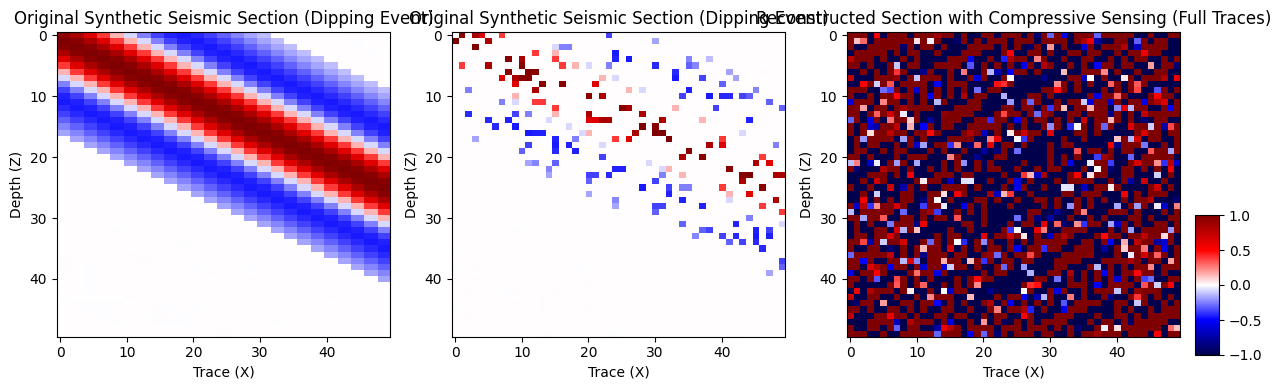

In [8]:
# Plots

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Original seismic section
axes[0].imshow(synthetic_seismic_section, cmap="seismic", aspect="auto", vmin=-1, vmax=1)
axes[0].set_title("Original Synthetic Seismic Section (Dipping Event)")
axes[0].set_xlabel("Trace (X)")
axes[0].set_ylabel("Depth (Z)")

# Sampled seismic
axes[1].imshow(observed_data_section.reshape((50,50)), cmap="seismic", aspect="auto", vmin=-1, vmax=1)
axes[1].set_title("Original Synthetic Seismic Section (Dipping Event)")
axes[1].set_xlabel("Trace (X)")
axes[1].set_ylabel("Depth (Z)")

# Reconstructed section
axes[2].imshow((Psi @ s_L1).reshape((50,50)), cmap="seismic", aspect="auto", vmin=-1, vmax=1)
axes[2].set_title("Reconstructed Section with Compressive Sensing (Full Traces)")
axes[2].set_xlabel("Trace (X)")
axes[2].set_ylabel("Depth (Z)")

# Colorbar
cbar_ax_seis = fig.add_axes([1.0, 0.10, 0.02, 0.35])  # [left, bottom, width, height]
cbar_seis = fig.colorbar(axes[1].images[0], cax=cbar_ax_seis, orientation='vertical')

plt.tight_layout()
plt.show()

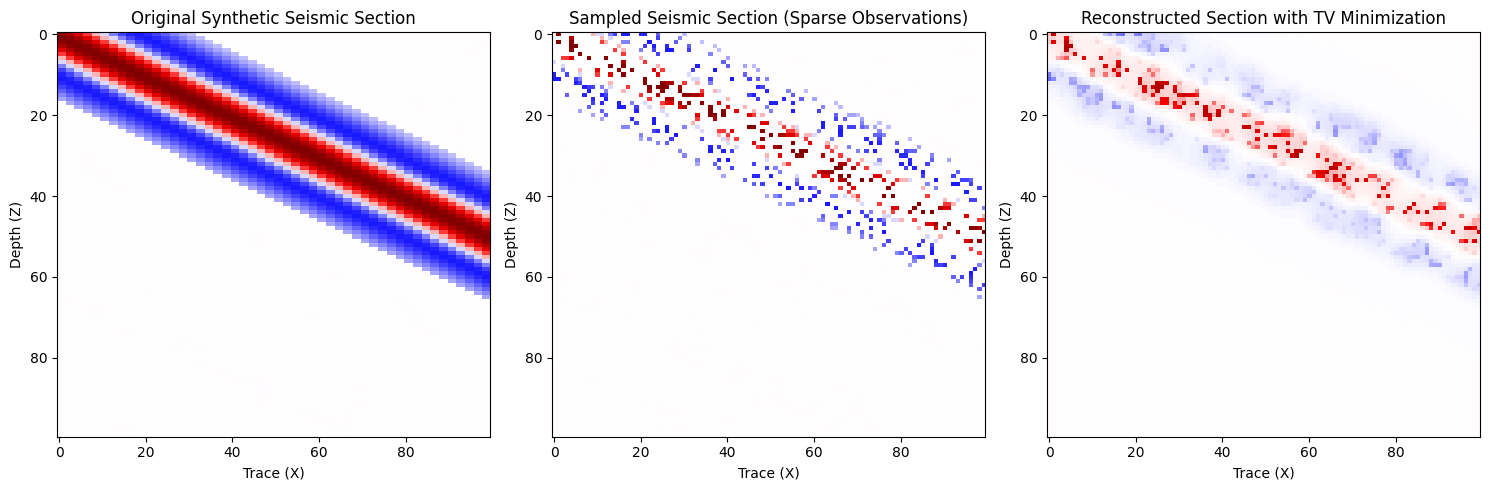

In [9]:
# Example with TVM and point samples

# Ricker wavelet function
def ricker_wavelet(points, a):
    t = np.arange(-points // 2, points // 2)
    y = (1 - 2 * (a * t / points) ** 2) * np.exp(-(a * t / points) ** 2)
    return y

# Reflectivity model
n_rows, n_cols = 100, 100
reflectivity_model = np.zeros((n_rows, n_cols))

# Dipping event
for i in range(n_rows):
    slope = 2  # Controls the dip
    j = int(i * slope)  # Calculate horizontal position for the dipping event
    if j < n_cols:
        reflectivity_model[i, j:j+2] = 1  # Add a dip with a unit reflectivity

# Convolution with reflectivity model
wavelet = ricker_wavelet(points=32, a=4)
synthetic_seismic_section = convolve(reflectivity_model, wavelet[:, np.newaxis], mode='same')

# Compressive sensing sampling
sparsity_fraction = 0.2
sampling_mask = np.random.rand(n_rows, n_cols) < sparsity_fraction
observed_data = np.zeros_like(synthetic_seismic_section)
observed_data[sampling_mask] = synthetic_seismic_section[sampling_mask]

# Reconstruction using Total Variation Minimization (TVM)
reconstructed_section = denoise_tv_chambolle(observed_data, weight=0.1)  # Removed multichannel argument

# Plots

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original seismic section
axes[0].imshow(synthetic_seismic_section, cmap="seismic", aspect="auto", vmin=-1, vmax=1)
axes[0].set_title("Original Synthetic Seismic Section")
axes[0].set_xlabel("Trace (X)")
axes[0].set_ylabel("Depth (Z)")

# Sampled seismic section
axes[1].imshow(observed_data, cmap="seismic", aspect="auto", vmin=-1, vmax=1)
axes[1].set_title("Sampled Seismic Section (Sparse Observations)")
axes[1].set_xlabel("Trace (X)")
axes[1].set_ylabel("Depth (Z)")

# Reconstructed section
axes[2].imshow(reconstructed_section, cmap="seismic", aspect="auto", vmin=-1, vmax=1)
axes[2].set_title("Reconstructed Section with TV Minimization")
axes[2].set_xlabel("Trace (X)")
axes[2].set_ylabel("Depth (Z)")

plt.tight_layout()
plt.show()


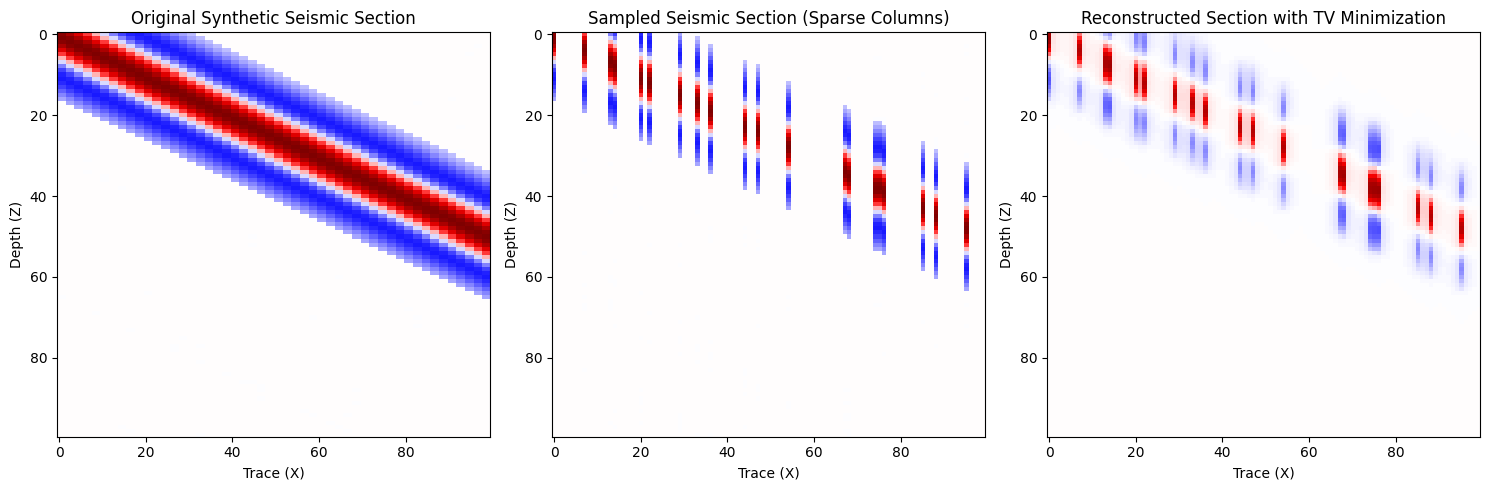

In [10]:
# # Example with TVM and whole traces as samples

# Ricker wavelet function
def ricker_wavelet(points, a):
    t = np.arange(-points // 2, points // 2)
    y = (1 - 2 * (a * t / points) ** 2) * np.exp(-(a * t / points) ** 2)
    return y

# Reflectivity model
n_rows, n_cols = 100, 100
reflectivity_model = np.zeros((n_rows, n_cols))

# Dipping event
for i in range(n_rows):
    slope = 2  # Controls the dip
    j = int(i * slope)  # Calculate horizontal position for the dipping event
    if j < n_cols:
        reflectivity_model[i, j:j+2] = 1  # Add a dip with a unit reflectivity

# Convolution with reflectivity model
wavelet = ricker_wavelet(points=32, a=4)
synthetic_seismic_section = convolve(reflectivity_model, wavelet[:, np.newaxis], mode='same')

# Compressive sensing sampling
sparsity_fraction = 0.2
selected_columns = np.random.choice(n_cols, size=int(n_cols * sparsity_fraction), replace=False)
sampling_mask = np.zeros((n_rows, n_cols), dtype=bool)
sampling_mask[:, selected_columns] = True  # Sample full traces (columns)

# Sampling mask (to simulate observed data)
observed_data = np.zeros_like(synthetic_seismic_section)
observed_data[sampling_mask] = synthetic_seismic_section[sampling_mask]

# Reconstruction using Total Variation Minimization (TVM)
reconstructed_section = denoise_tv_chambolle(observed_data, weight=0.1)  # Removed multichannel argument

# Plots

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original seismic section
axes[0].imshow(synthetic_seismic_section, cmap="seismic", aspect="auto", vmin=-1, vmax=1)
axes[0].set_title("Original Synthetic Seismic Section")
axes[0].set_xlabel("Trace (X)")
axes[0].set_ylabel("Depth (Z)")

# Sampled seismic section
axes[1].imshow(observed_data, cmap="seismic", aspect="auto", vmin=-1, vmax=1)
axes[1].set_title("Sampled Seismic Section (Sparse Columns)")
axes[1].set_xlabel("Trace (X)")
axes[1].set_ylabel("Depth (Z)")

# Reconstructed section
axes[2].imshow(reconstructed_section, cmap="seismic", aspect="auto", vmin=-1, vmax=1)
axes[2].set_title("Reconstructed Section with TV Minimization")
axes[2].set_xlabel("Trace (X)")
axes[2].set_ylabel("Depth (Z)")

plt.tight_layout()
plt.show()


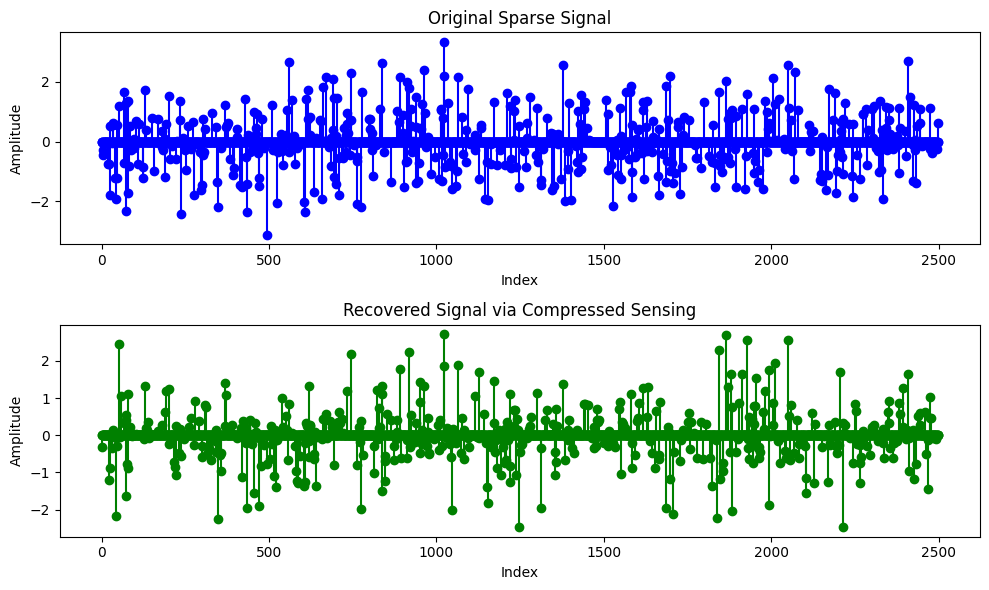

Mean Squared Error of Reconstruction: 0.1781


In [11]:
# 1D Example using cvxpy

# Dimensions
n = 2500               # Dimension of the sparse signal `s`
sparsity_fraction = 0.2 # Fraction of the signal that is non-zero
p = int(sparsity_fraction * n)  # Number of measurements

# Sparse signal 's' with a few non-zero elements
true_s = np.zeros(n)
non_zero_indices = np.random.choice(np.arange(n), size=int(n * sparsity_fraction), replace=False)
true_s[non_zero_indices] = np.random.randn(len(non_zero_indices))

# Measurement matrix Theta and measurement vector y
Theta = np.random.randn(p, n)  # Gaussian random matrix
y = Theta @ true_s             # Measurements

# L1-norm minimization using CVXPY (for better stability and speed)
s = cp.Variable(n)
objective = cp.Minimize(cp.norm(s, 1))
constraints = [Theta @ s == y]
problem = cp.Problem(objective, constraints)
problem.solve()

# Recovered signal
recovered_s = s.value

# Plots

fig, axes = plt.subplots(2, 1, figsize=(10, 6))

# Original sparse signal
axes[0].stem(true_s, linefmt='b-', markerfmt='bo', basefmt=" ")
axes[0].set_title("Original Sparse Signal")
axes[0].set_xlabel("Index")
axes[0].set_ylabel("Amplitude")

# Recovered sparse signal
axes[1].stem(recovered_s, linefmt='g-', markerfmt='go', basefmt=" ")
axes[1].set_title("Recovered Signal via Compressed Sensing")
axes[1].set_xlabel("Index")
axes[1].set_ylabel("Amplitude")

plt.tight_layout()
plt.show()

# Reconstruction error
mse = np.mean((true_s - recovered_s) ** 2)
print(f"Mean Squared Error of Reconstruction: {mse:.4f}")


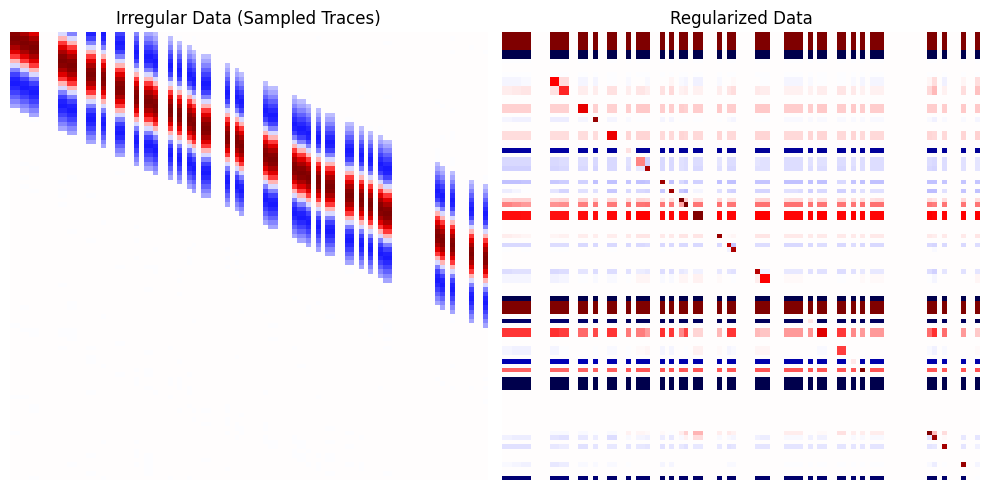

In [13]:
# Siwei Yu, Jianwei Ma, y Bangliu Zhao, «Off-the-Grid Vertical Seismic Profile Data Regularization by a Compressive Sensing Method», GEOPHYSICS 85, n.º 2 (1 de marzo de 2020): V157-68,
# https://doi.org/10.1190/geo2019-0357.1.
# Algorithm 1. Optimization algorithm for data regularization.

# TO BE REVIEWED

# Synthetic seismic data and initialization parameters
n_rows, n_cols = 100, 100
synthetic_seismic = np.random.randn(n_rows, n_cols)
synthetic_seismic = synthetic_seismic_section

# Random selection of columns as irregular data
sparsity_fraction = 0.5
selected_columns = np.random.choice(n_cols, size=int(sparsity_fraction * n_cols), replace=False)
A = np.zeros((n_rows, n_cols))
A[:, selected_columns] = 1  # Mask matrix to select full columns for irregular data
b = synthetic_seismic * A  # Irregular data

# Parameters
beta = 10
mu = 4
nu = 1

# Initialization of variables
u_k = np.zeros_like(b)
omega_k = np.zeros_like(b)
v_k = np.zeros_like(b)
lambda_k = np.zeros_like(b)


# Derivative operator D (simple difference operator in this example)
def D(u):
    return np.roll(u, -1, axis=0) - u  # Finite difference along rows

def D_T(u):
    return np.roll(u, 1, axis=0) - u  # Transpose of D


# Iteration process
max_iters = 100
for k in range(max_iters):
    # Step 1: Update of omega
    D_u_k = D(u_k)
    omega_k = np.maximum(np.abs(D_u_k - v_k / beta) - 1 / beta, 0) * np.sign(D_u_k - v_k / beta)
    
    # Step 2: Update of u
    term1 = beta * D_T(D(u_k)) + mu * (A.T @ A)
    term2 = D_T(v_k + beta * omega_k) + A.T @ (lambda_k + mu * b)
    u_k = np.dot(pinv(term1), term2)  # Use pseudoinverse for stability

    # Step 3: Dual update
    v_k = v_k - beta * (D(u_k) - omega_k)
    lambda_k = lambda_k - mu * (A @ u_k - b)
    
    # Convergence check (optional, based on tolerance)
    if np.linalg.norm(D(u_k) - omega_k) < 1e-6 and np.linalg.norm(A @ u_k - b) < 1e-6:
        break

# Result, regularized data in u_k
regularized_data = u_k

# Plots

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Original irregular data
axes[0].imshow(b, cmap="seismic", aspect="auto", vmin=-1, vmax=1)
axes[0].set_title("Irregular Data (Sampled Traces)")
axes[0].axis('off')

# Regularized data
axes[1].imshow(regularized_data, cmap="seismic", aspect="auto", vmin=-1, vmax=1)
axes[1].set_title("Regularized Data")
axes[1].axis('off')

plt.tight_layout()
plt.show()
